# Planewaves in Homogeneous Media

The eigenmode source can also be used to launch [planewaves](https://en.wikipedia.org/wiki/Plane_wave) in homogeneous media. The dispersion relation for a planewave is ω=|$\vec{k}$|/$n$ where ω is the angular frequency of the planewave and $\vec{k}$ its wavevector; $n$ is the refractive index of the homogeneous medium. This example demonstrates launching planewaves in a uniform medium with $n$ of 1.5 at three rotation angles: 0°, 20°, and 40°. Bloch-periodic boundaries via the `k_point` are used and specified by the wavevector $\vec{k}$. PML boundaries are used only along the x-direction.

First, we'll load our necesarry modules:

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

Next, we'll create a function we can call multiple times that runs the simulation for different rotation angles:

In [2]:
import meep as mp
import numpy as np
import h5py

# --- Global Parameters ---
resolution = 20
fcen = 1.0
df = 0.2
sx, sy, sz = 4, 4, 8
cell_size = mp.Vector3(sx, sy, sz)
epsilon_material = 2.56

# --- Fixed k-vector (30° from vertical) ---
angle_rad = np.radians(30)
k_mag = 2 * np.pi * fcen
kx = k_mag * np.sin(angle_rad)
ky = -k_mag * np.cos(angle_rad)
k_fixed = mp.Vector3(kx, ky, 0)

# --- Simulation function ---
def run_sim():
    # Geometry: half-space and sphere
    geometry = [
        mp.Block(
            center=mp.Vector3(0, -sy / 4, 0),
            size=mp.Vector3(mp.inf, sy / 2, mp.inf),
            material=mp.Medium(epsilon=epsilon_material)
        ),
        mp.Sphere(
            radius=1.0,
            center=mp.Vector3(0, 1, 0),
            material=mp.Medium(epsilon=epsilon_material)
        )
    ]

    sources = [mp.EigenModeSource(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        center=mp.Vector3(0, 2, 0),
        size=mp.Vector3(sx, 0, sz),
        direction=mp.NO_DIRECTION,
        eig_kpoint=k_fixed,
        eig_band=1,
        eig_parity=mp.ODD_Z,
        eig_match_freq=True
    )]

    # Simulation
    sim = mp.Simulation(
        cell_size=cell_size,
        resolution=resolution,
        boundary_layers=[mp.PML(1.0)],
        geometry=geometry,
        sources=sources,
        dimensions=3,
        k_point=k_fixed
    )

    sim.run(until=200)

    # Output Ez field
    ez_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ez)
    with h5py.File("ez_fixed_k.h5", "w") as f:
        f.create_dataset("Ez", data=ez_data)

    print("✅ Simulation complete. Field saved to ez_fixed_k.h5")

# --- Run it ---
run_sim()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000899792 s
Working in 3D dimensions.
Computational cell is 4 x 4 x 8 with resolution 20
     block, center = (0,-1,0)
          size (1e+20,2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     sphere, center = (0,1,0)
          radius 1
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 12.9048 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(3.14159,-5.4414,0) = 4.03349 after 30 iters
MPB solved for frequency_1(0.670856,-1.16196,0) = 0.989239 after 38 iters
MPB solved for frequency_1(0.678719,-1.17558,0) = 0.999981 after 27 iters
MPB solved for frequency_1(0.678733,-1.1756,0) = 1 after 8 iters
MPB solved for frequency_1(0.678733,-1.1756,0) = 1 after 1 iters
Meep progress: 0.1/200.0 = 0.1% done in 4.0s, 8034.5s to go
on time step 4 (time=0.1), 1.00487 s/step
Meep progress: 1.275000000000000

Next we'll iterate over three rotation angles and plot their steady-state fields profiles. Residues of the backward-propagating waves due to the discretization are slightly visible.

Ez shape: (82, 82, 162), dtype: complex128


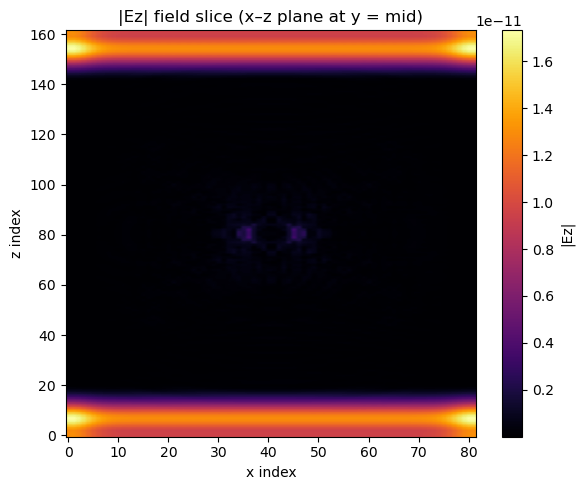

In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# --- Load Ez field ---
with h5py.File("ez_fixed_k.h5", "r") as f:
    ez = f["Ez"][:]  # shape: (Nx, Ny, Nz), dtype: complex128

print(f"Ez shape: {ez.shape}, dtype: {ez.dtype}")

# --- Choose a 2D slice (x–z plane at middle y) ---
mid_y = ez.shape[1] // 2
ez_slice = ez[:, mid_y, :]  # shape: (Nx, Nz), still complex

# --- Compute magnitude ---
field_to_plot = np.abs(ez_slice)  # magnitude of Ez

# --- Plot ---
plt.figure(figsize=(6, 5))
plt.imshow(field_to_plot.T, origin="lower", cmap="inferno", aspect="auto")
plt.title("|Ez| field slice (x–z plane at y = mid)")
plt.xlabel("x index")
plt.ylabel("z index")
plt.colorbar(label="|Ez|")
plt.tight_layout()
plt.show()


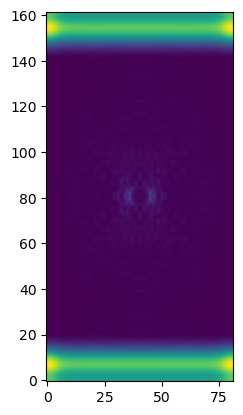

In [4]:
ez_abs = np.abs(ez_slice)
plt.imshow(ez_abs.T, cmap="viridis", origin="lower")


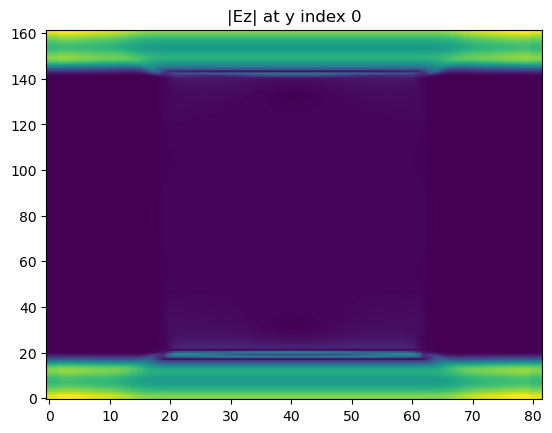

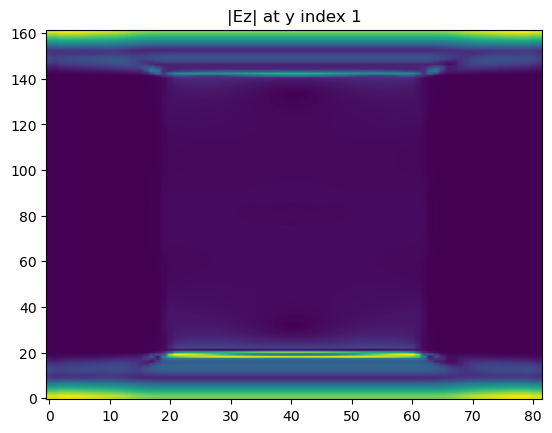

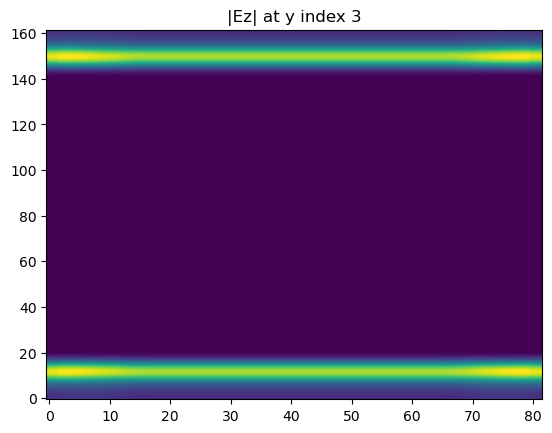

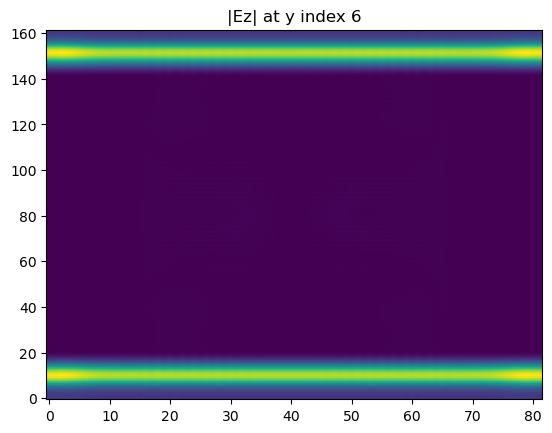

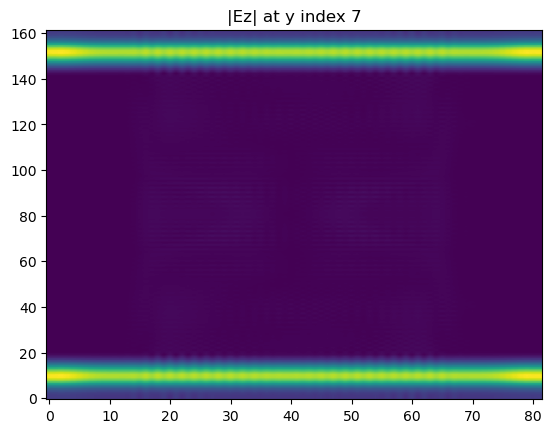

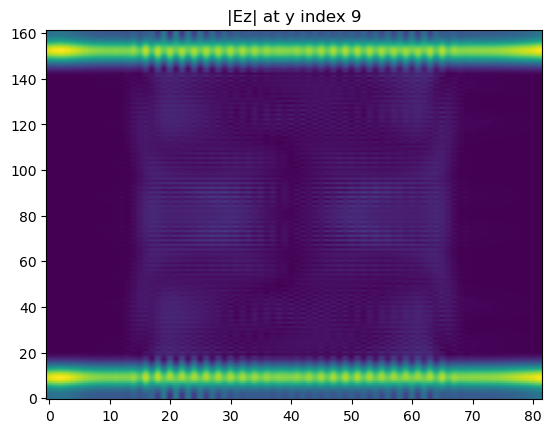

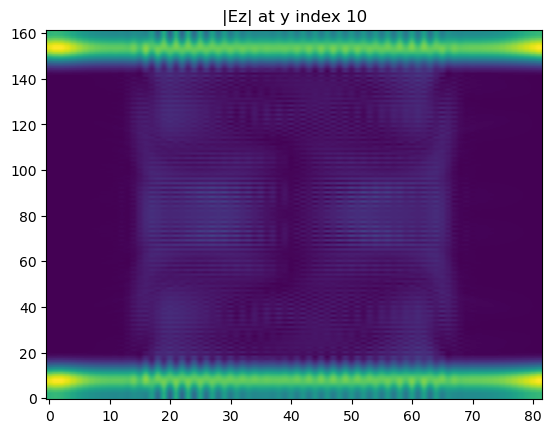

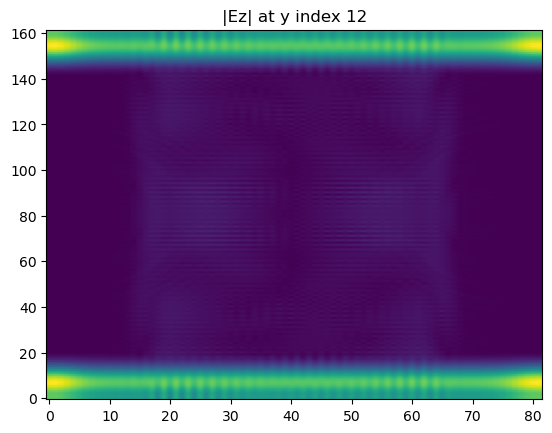

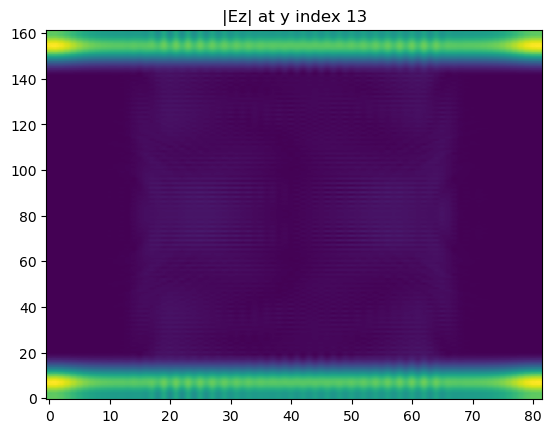

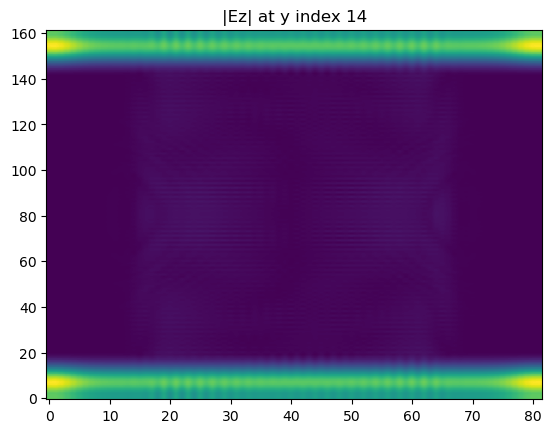

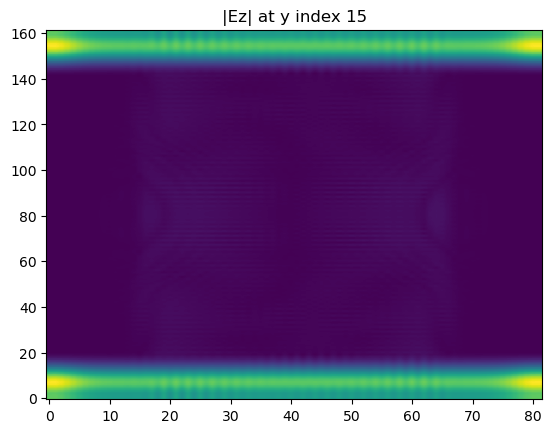

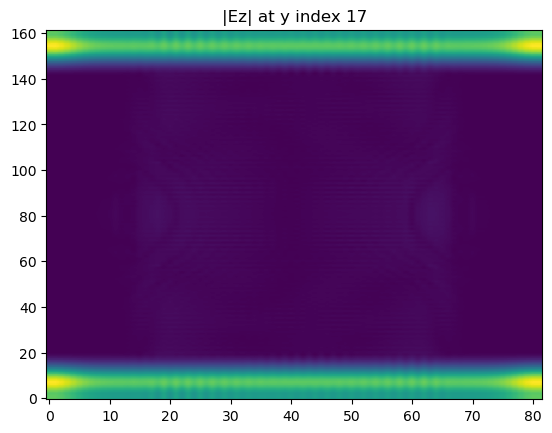

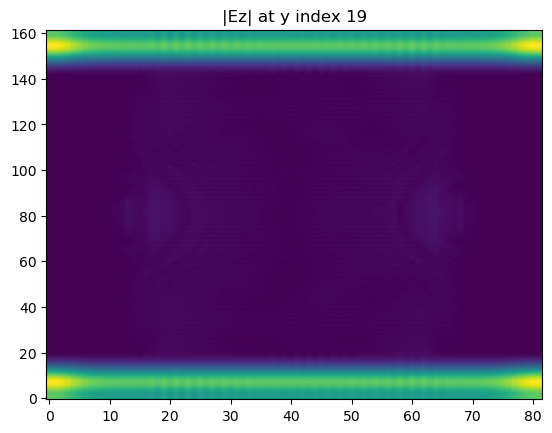

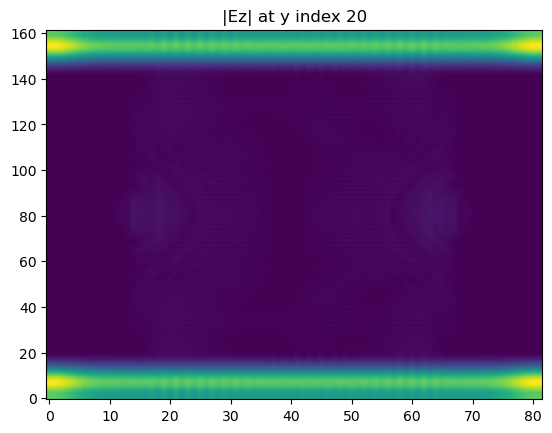

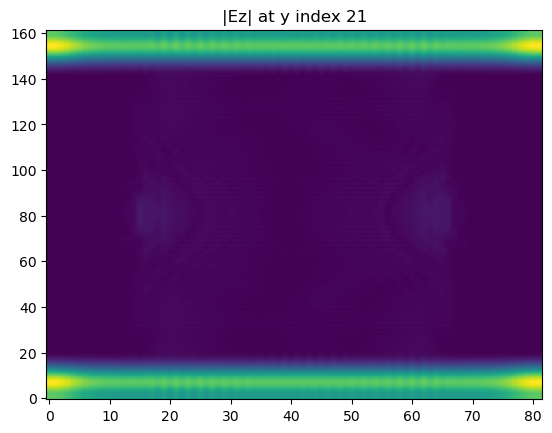

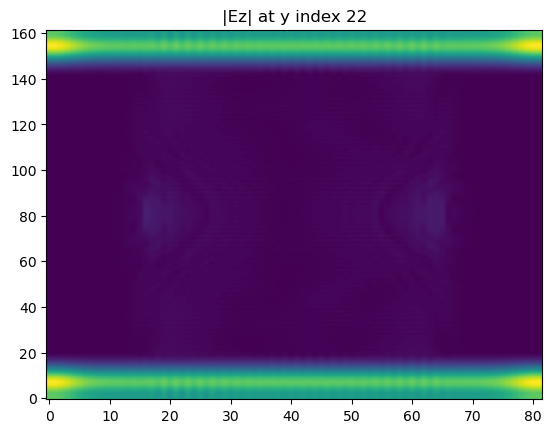

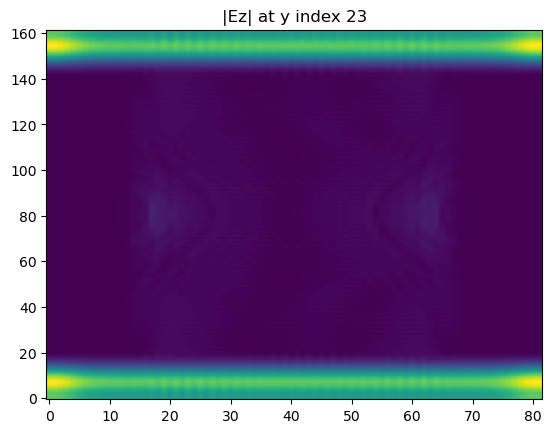

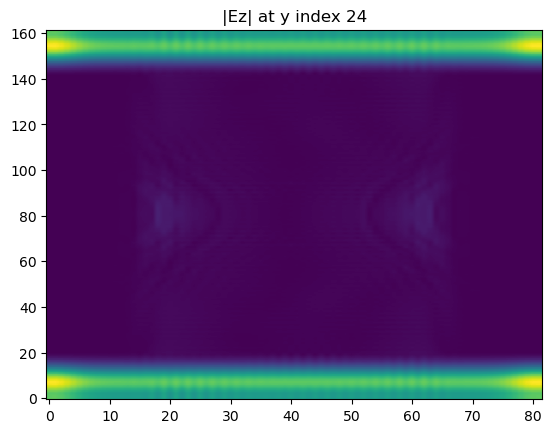

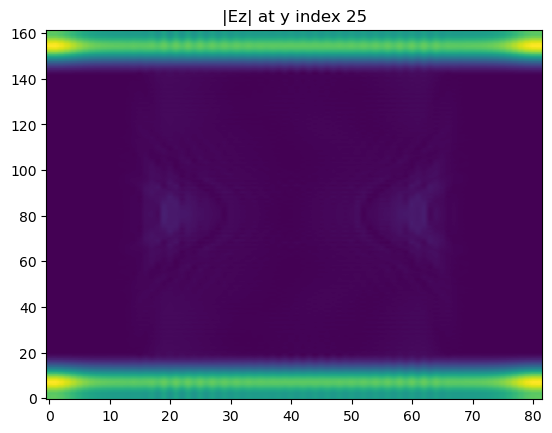

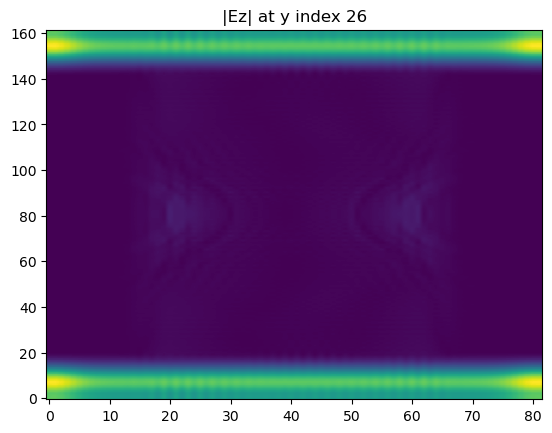

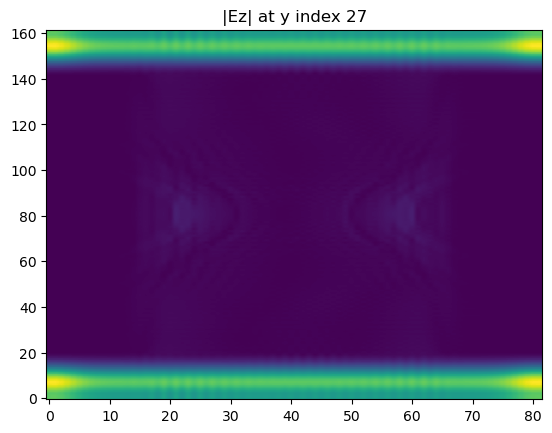

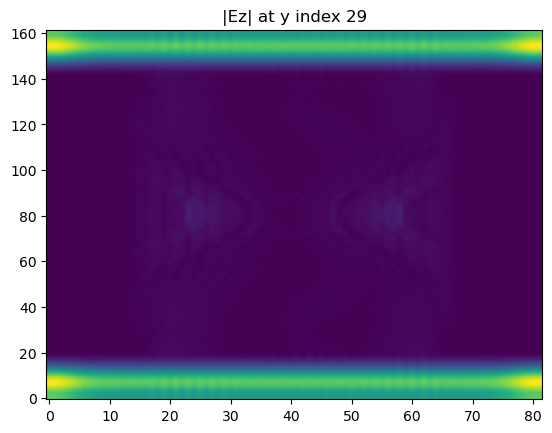

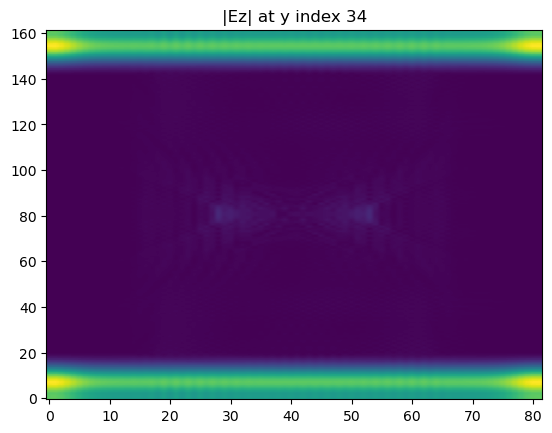

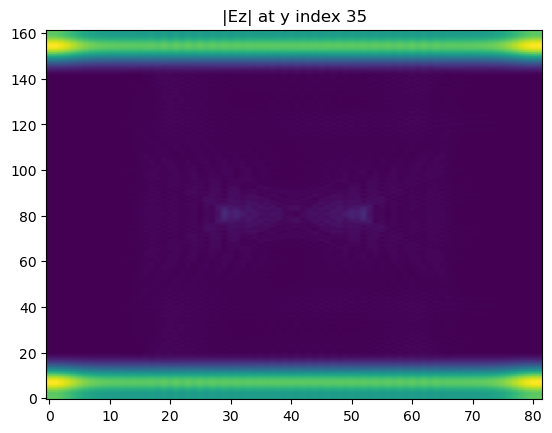

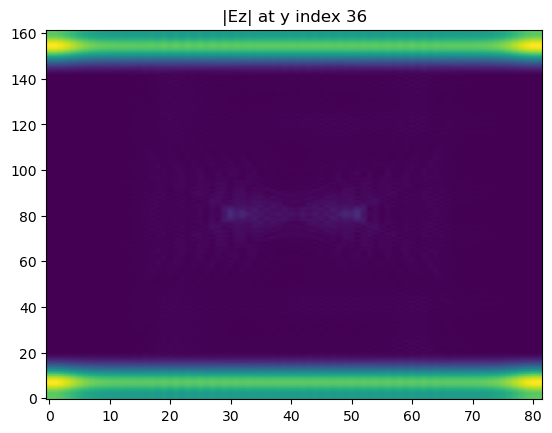

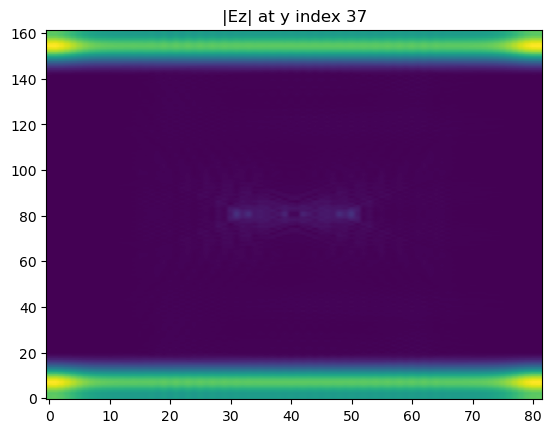

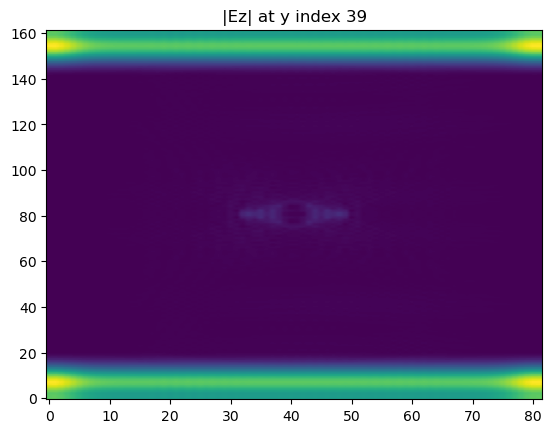

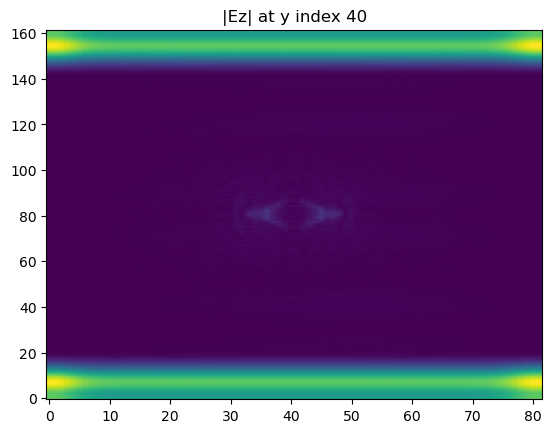

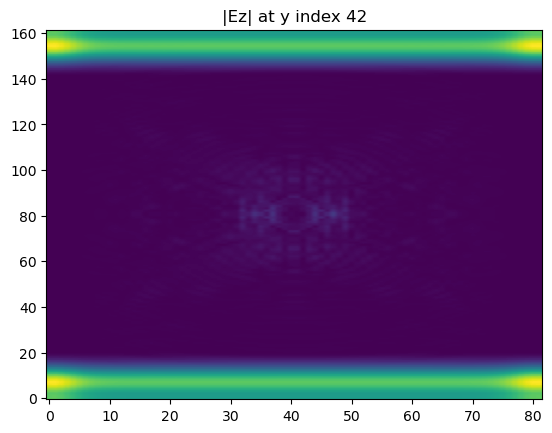

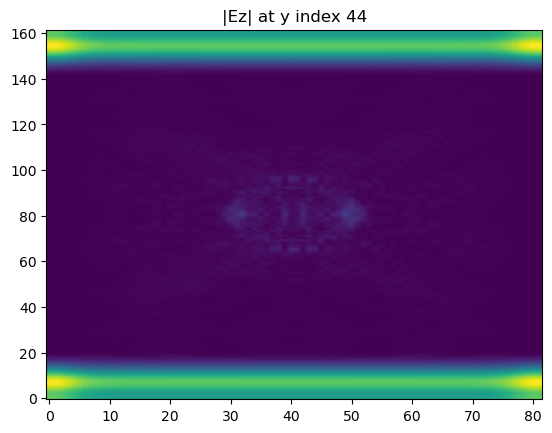

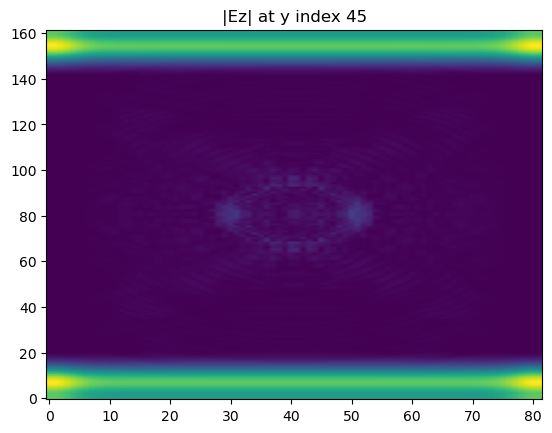

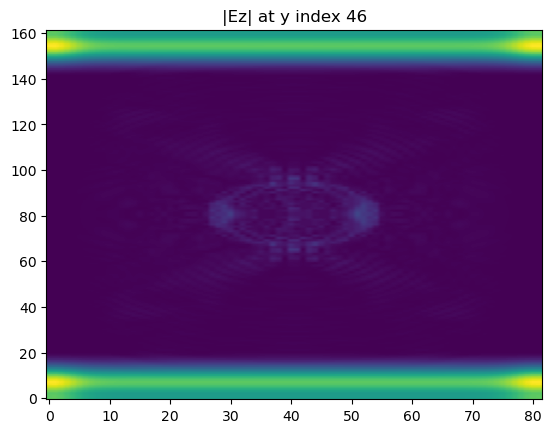

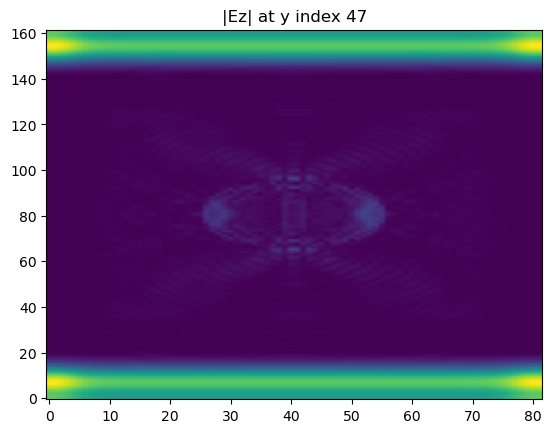

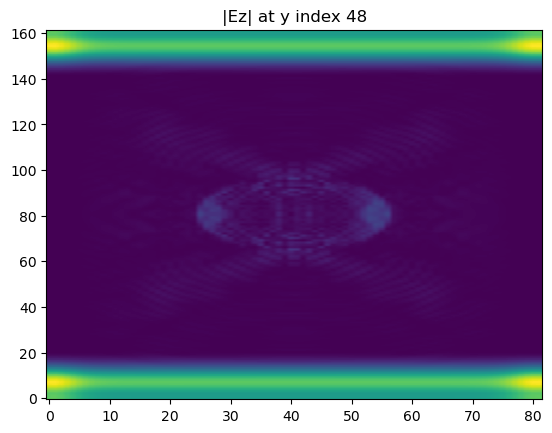

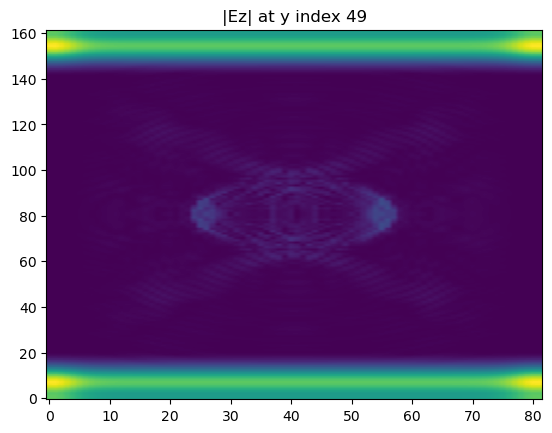

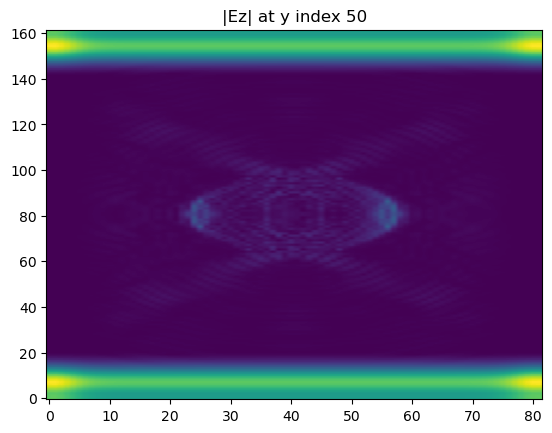

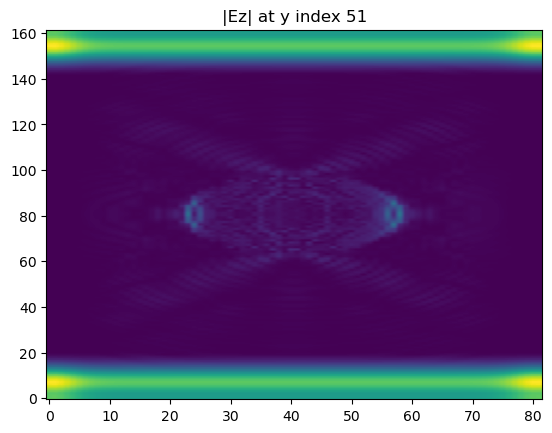

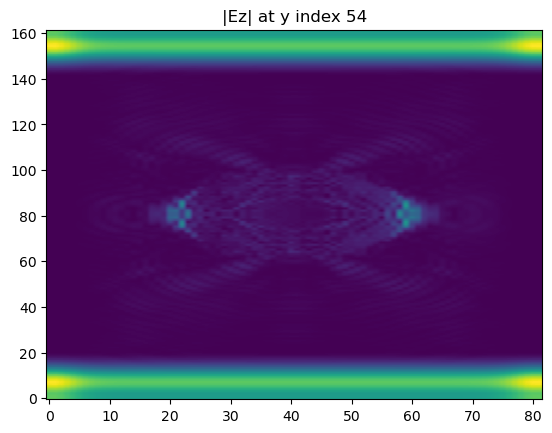

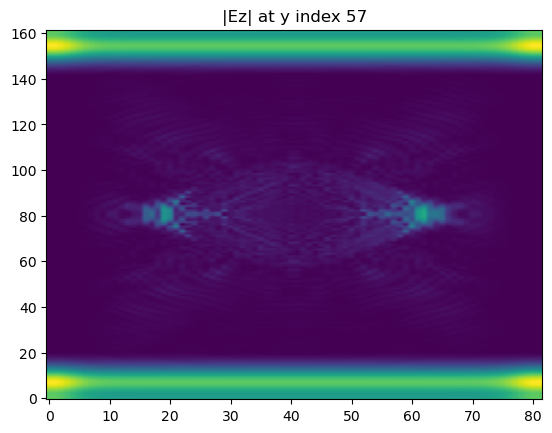

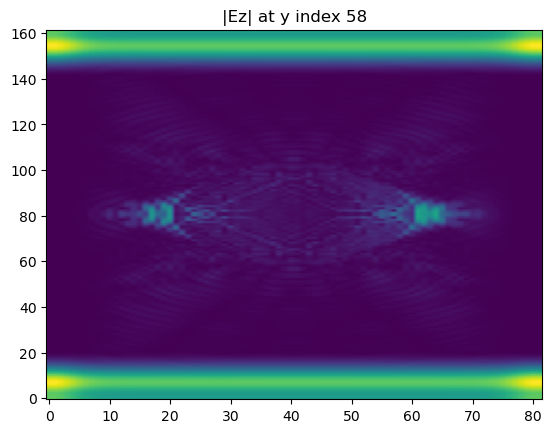

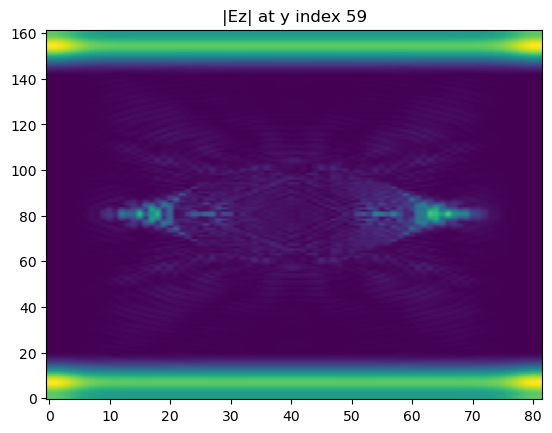

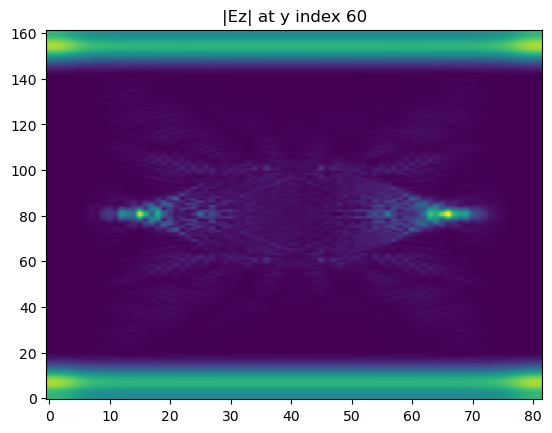

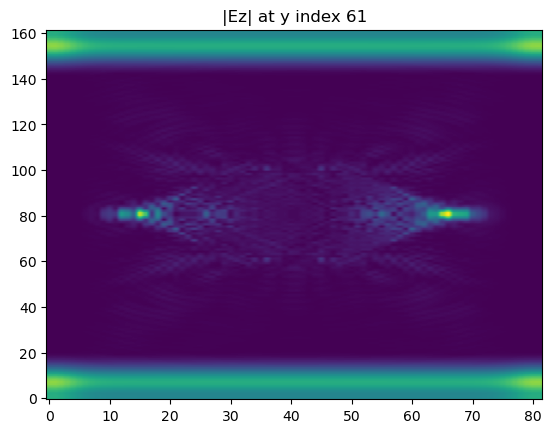

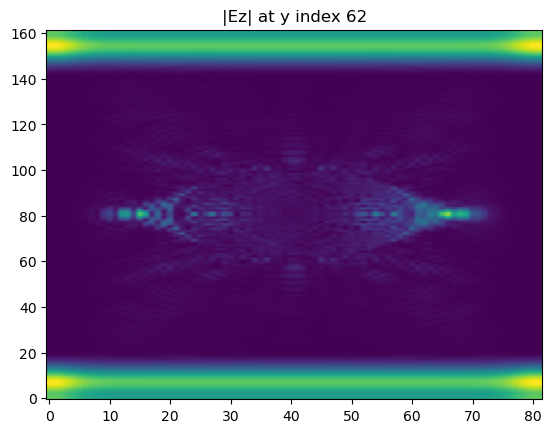

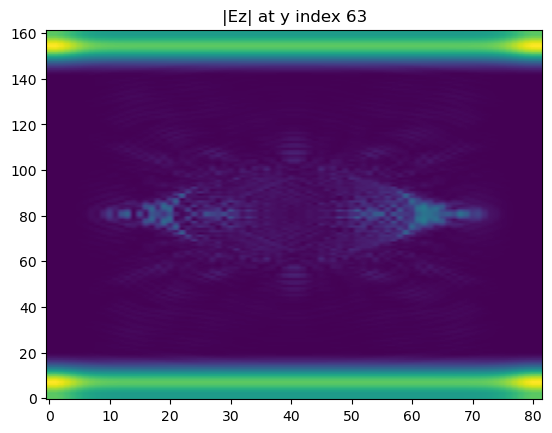

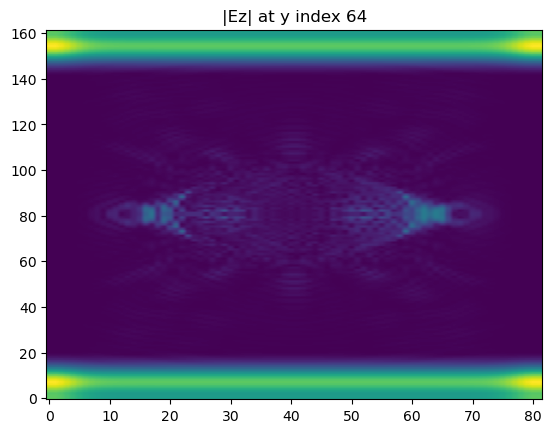

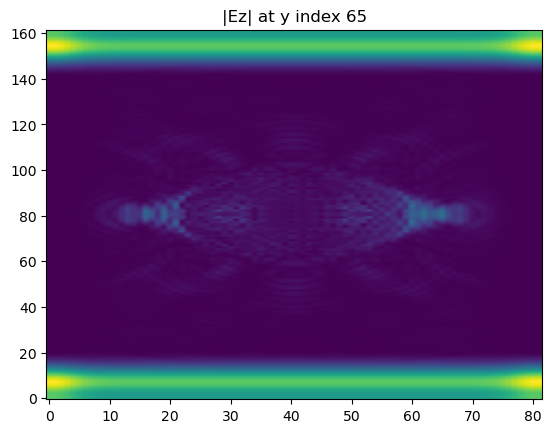

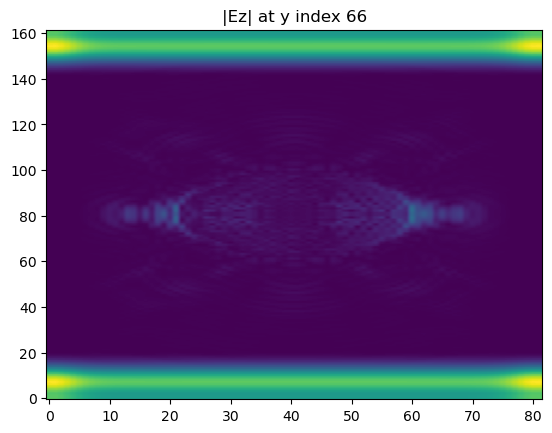

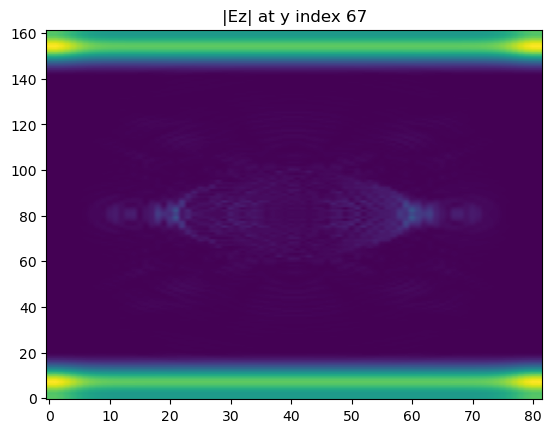

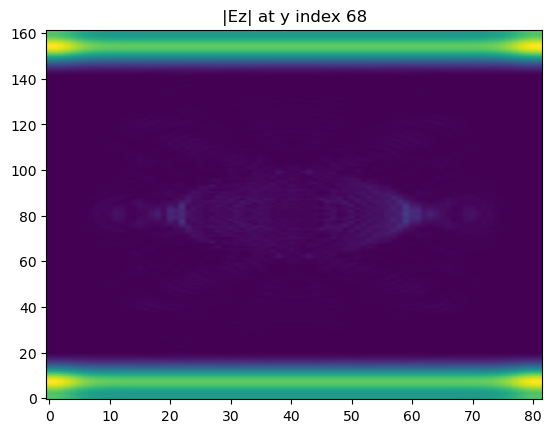

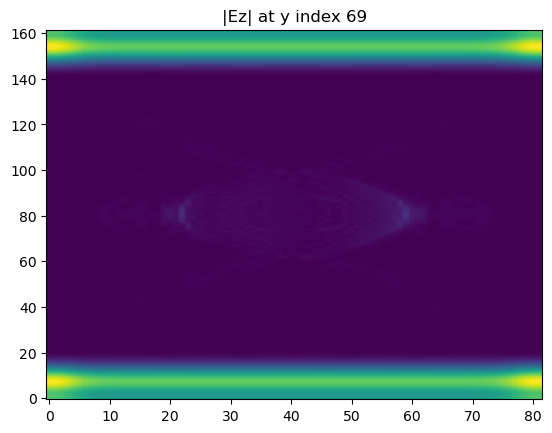

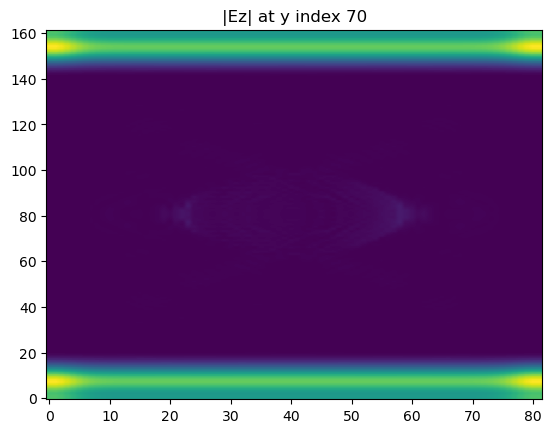

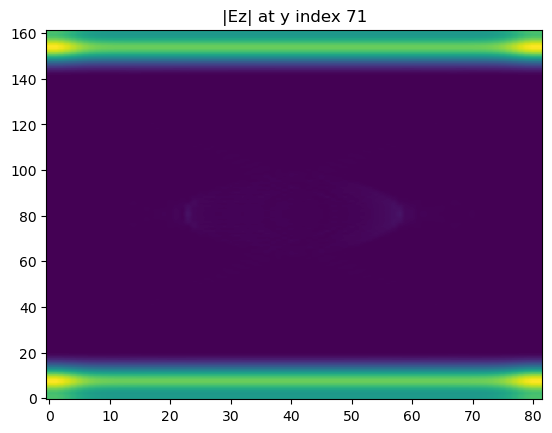

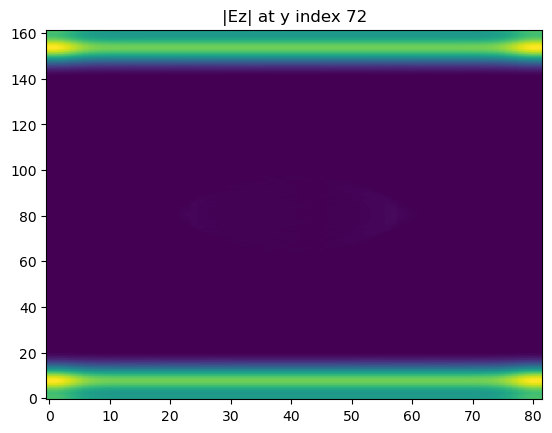

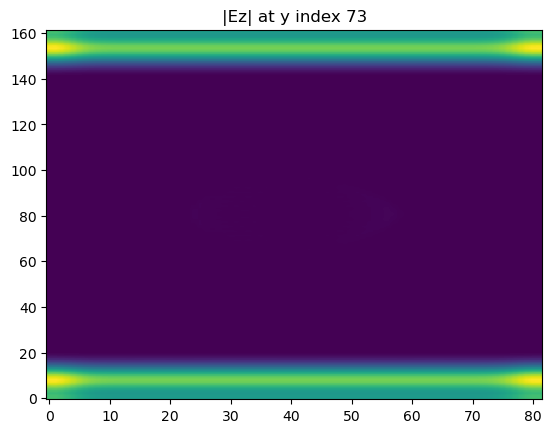

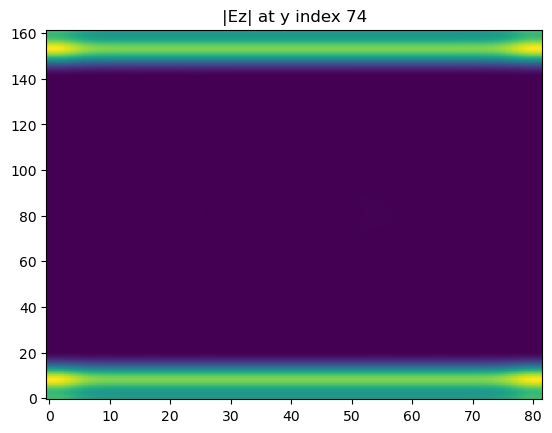

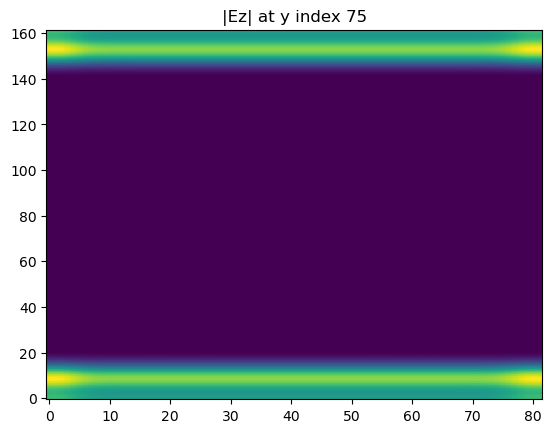

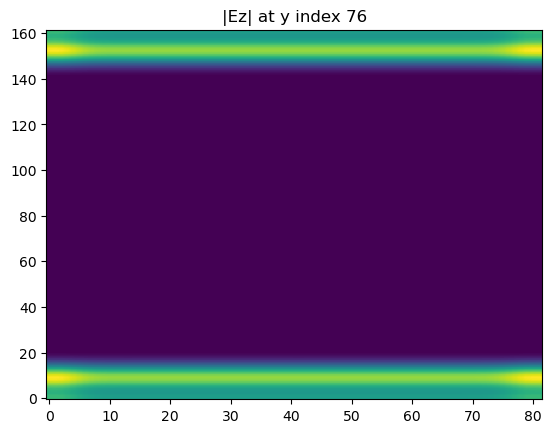

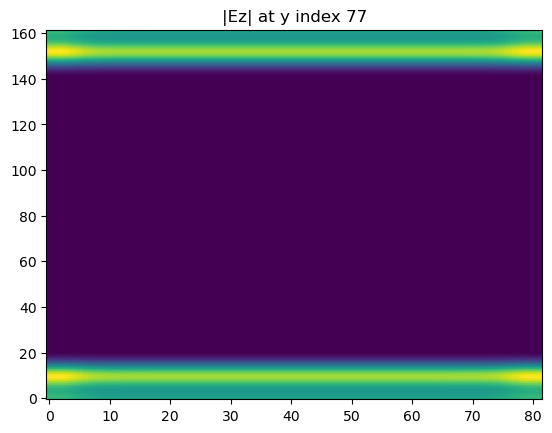

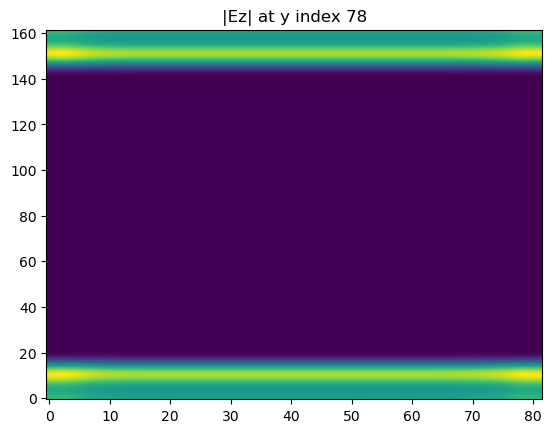

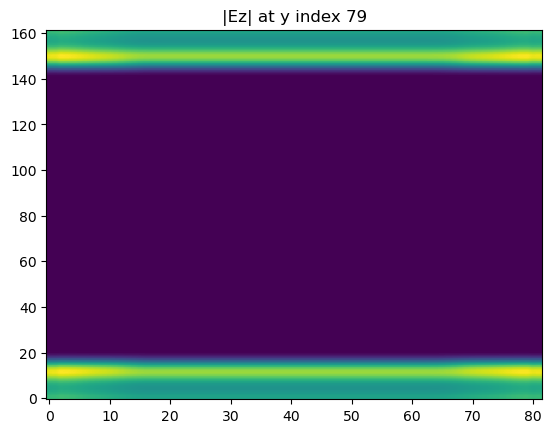

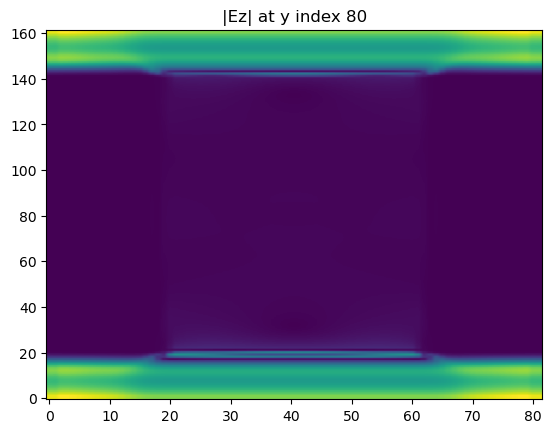

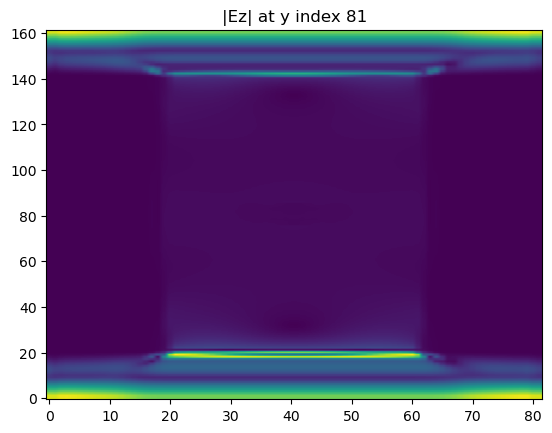

In [5]:
for i in range(ez.shape[1]):
    plt.clf()
    plt.imshow(np.abs(ez[:, i, :]).T, origin="lower", cmap="viridis", aspect="auto")
    plt.title(f"|Ez| at y index {i}")
    plt.pause(0.1)


In [6]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# --- Load Ex, Ey, Ez from HDF5 file ---
with h5py.File("ez_fixed_k.h5", "r") as f:
    ez = f["Ez"][:]

# If you haven't saved Ex and Ey yet, load them like this:
# Save these from your simulation the same way you did for Ez
with h5py.File("ex_fixed_k.h5", "r") as f:
    ex = f["Ex"][:]

with h5py.File("ey_fixed_k.h5", "r") as f:
    ey = f["Ey"][:]

# --- Calculate |E| ---
abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

# --- Choose slice (x–z at middle y) ---
mid_y = abs_E.shape[1] // 2
abs_slice = abs_E[:, mid_y, :]

# --- Plot ---
plt.figure(figsize=(6, 5))
plt.imshow(abs_slice.T, cmap="viridis", origin="lower", aspect="auto")
plt.title("Electric field magnitude |E| (x–z slice at mid y)")
plt.xlabel("x index")
plt.ylabel("z index")
plt.colorbar(label="|E|")
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'ex_fixed_k.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Save Ex and Ey as well
ex_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ex)
ey_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ey)

with h5py.File("ex_fixed_k.h5", "w") as f:
    f.create_dataset("Ex", data=ex_data)

with h5py.File("ey_fixed_k.h5", "w") as f:
    f.create_dataset("Ey", data=ey_data)


Note that this example involves a `ContinuousSource` for the time profile. For a pulsed source, the oblique planewave is incident at a given angle for only a *single* frequency component of the source. This is a fundamental feature of FDTD simulations and not of Meep per se. Thus, to simulate an incident planewave at multiple angles for a given frequency ω, you will need to do separate simulations involving different values of $\vec{k}$ (`k_point`) since each set of ($\vec{k}$,ω) specifying the Bloch-periodic boundaries and the frequency of the source will produce a different angle of the planewave. For more details, refer to Section 4.5 ("Efficient Frequency-Angle Coverage") in [Chapter 4](https://arxiv.org/abs/1301.5366) ("Electromagnetic Wave Source Conditions") of [Advances in FDTD Computational Electrodynamics: Photonics and Nanotechnology](https://www.amazon.com/Advances-FDTD-Computational-Electrodynamics-Nanotechnology/dp/1608071707).